In [16]:
# For data generation
import sys
# cupy-cuda12x
# !{sys.executable} -m  pip install shap numba --force-reinstall
# !{sys.executable} -m  pip install seaborn matplotlib tqdm
#-m  pip install --upgrade  shap mendeleev scikit-learn scipy numpy joblib  --force-reinstall
import shutil
import os
import numpy as np
# import cupy as cp
from glob import glob
import re
import pandas as pd
import pickle
#random
from time import perf_counter

# sklearn
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200

import warnings

from sklearn.preprocessing import normalize


from tqdm.auto import tqdm
# from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
feat_name=['From_Same_Orbital', 'pair_energy', 'coulomb', 'screen1_1', 'screen1_2',
       'screen1_3', 'screen1_4', 'screen2_1', 'screen2_2', 'screen2_3',
       'screen2_4', 'eijab_1', 'eijab_2', 'eijab_3', 'eijab_4', 'screenvirt_1',
       'screenvirt_2', 'screenvirt_3', 'screenvirt_4', 'Fr1', 'Fr2', 'Fr3',
       'Fr4', 'Fs1', 'Fs2', 'Fs3', 'Fs4', 'occr1', 'occr2', 'occr3', 'occr4',
       'occs1', 'occs2', 'occs3', 'occs4', 'SCFFr1', 'SCFFr2', 'SCFFr3',
       'SCFFr4', 'SCFFs1', 'SCFFs2', 'SCFFs3', 'SCFFs4', 'SCFOCCr1',
       'SCFOCCr2', 'SCFOCCr3', 'SCFOCCr4', 'SCFOCCs1', 'SCFOCCs2', 'SCFOCCs3',
       'SCFOCCs4', 'hrr1', 'hrr2', 'hrr3', 'hrr4', 'hss1', 'hss2', 'hss3',
       'hss4', 'hpp', 'hqq', 'Fp', 'Fq', 'occp', 'occq', 'SCFFp', 'SCFFq',
       'SCFOCCp', 'SCFOCCq']



# feat_name=['screen1_1', 'screen1_2', 'screen1_3', 'screen1_4', 'screen2_1',
#            'screen2_2', 'screen2_3', 'screen2_4', 'eijab_1', 'eijab_2','eijab_3', 'screenvirt_1', 'screenvirt_2', 'screenvirt_3',
#            'screenvirt_4', 'Fr1', 'Fr2', 'Fr3', 'Fr4', 'Fs1', 'Fs2', 'Fs3',
#            'Fs4', 'SCFFr2', 'SCFFs1', 'SCFFs2', 'SCFFs3', 'SCFFs4', 'hrr1',
#            'hrr2', 'hrr3', 'hrr4', 'hss1', 'hss2', 'hss3', 'hss4', 'hpp',
#            'Fp', 'Fq', 'occq']

In [ ]:
def load_data(path):
    with open(os.path.join(path,'test_ind.pickle'), 'rb') as handle:
        test_ind = pickle.load(handle)
    
    with open(os.path.join(path,'train_ind.pickle'), 'rb') as handle:
        train_ind = pickle.load(handle)
        
    print(len(train_ind),len(test_ind))    
    
    train_X=[]
    train_y = []
    
    test_X=[]
    test_y = []
    # for nam in sorted(glob('*/fixed_feats.pickle'),key=lambda x: int(x.split('_')[0].strip('H')))[2:]:
    for nam in glob(os.path.join(path,'*/fixed_feats.pickle')):
        trydf=pd.read_pickle(nam).astype(float)[feat_name]    
        Hnam=os.path.basename(os.path.dirname(nam)).split('_')[0]
        for i in train_ind:
            train_X.append(trydf.loc[f'{Hnam}_chain/{Hnam}_{i:.2f}/'].values)
        for j in test_ind: 
            test_X.append(trydf.loc[f'{Hnam}_chain/{Hnam}_{j:.2f}/'].values)
        
    recover_train=[]    
    recover_test=[]    
    tst_idx=0
    tr_idx=0
    for nidx,nam in enumerate(glob(os.path.join(path,'*/fixed_targets.pickle'))):
        trydf=pd.read_pickle(nam).astype(float)
        Hnam=os.path.basename(os.path.dirname(nam)).split('_')[0]
        for tridx,i in enumerate(train_ind):
            pairdf=trydf[f'{i:.2f}'].values
            train_y.append(pairdf)
            for k in range(len(pairdf)):
                recover_train.append((Hnam,tridx,tr_idx))
                tr_idx+=1
            
        for teidx,j in enumerate(test_ind): 
            pairdf=trydf[f'{j:.2f}'].values
            test_y.append(pairdf)        
            
            for k in range(len(pairdf)):
                recover_test.append((Hnam,teidx,tst_idx))
                tst_idx+=1
                
    X_train, X_test=np.vstack(train_X).astype(float),np.vstack(test_X).astype(float)
    y_train,y_test=np.hstack(train_y).astype(float),np.hstack(test_y).astype(float)
    print(X_train.shape,X_test.shape)
    print(y_train.shape,y_test.shape)
    for u,v in np.argwhere(np.isnan(X_train)):
        X_train[u,v]=0
        
    for u,v in np.argwhere(np.isnan(X_test)):
        X_test[u,v]=0    
    
    for u,v in np.argwhere(np.isinf(X_train)):
        X_train[u,v]=0
        
    for u,v in np.argwhere(np.isinf(X_test)):
        X_test[u,v]=0         

    scaler=MinMaxScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    return X_train, X_test, y_train, y_test, recover_train, recover_test, train_ind, test_ind

In [ ]:
H_path = "../hydrogen_comps/minimal_2e_2o/chains/even/"

X_train, X_test, y_train, y_test, recover_train, recover_test, train_ind, test_ind = load_data(H_path)

In [ ]:

# model=XGBRegressor(reg_lambda=0.3,max_depth=100,min_child_weight=5)

params = {'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 10,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': np.nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 500,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 0.001,
 'reg_lambda': 0.001,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

model=XGBRegressor(**params)
model.fit(X_train,y_train)
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)
print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")

# params = {'max_depth': [1, 10, 100],
#           'n_estimators': [100, 500, 1000],
#           'reg_lambda': [1e-6, 1e-3,1e-1],
#           'reg_alpha': [1e-6, 1e-3,1e-1]}

# model = XGBRegressor()
# grid = GridSearchCV(estimator=model, 
#                    param_grid=params,
#                    scoring='r2', 
#                    verbose=0,n_jobs=12).fit(X_train,y_train)


# gmodel=grid.best_estimator_
# y_pred_train=gmodel.predict(X_train)
# y_pred_test=gmodel.predict(X_test)
# print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
# print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")



In [ ]:
# model.save_model("full_hmodel.json")

In [ ]:
pal = sns.color_palette("Paired")

In [ ]:
pal[4]

In [ ]:
font=12
plt.rc('font', size=font)          # controls default text sizes
plt.rc('axes', titlesize=font)     # fontsize of the axes title
plt.rc('axes', labelsize=font)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font)    # fontsize of the tick labels
plt.rc('legend', fontsize=font)    # legend fontsize
plt.rc('figure', titlesize=font)  # fontsize of the figure title
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(13,6))
scale=1e-1
ax1.set_title('Train')
ax1.scatter(1e3*y_train,1e3*y_pred_train,label="R$^{2}$="+f'{r2_score(y_train,y_pred_train):.2f}\nMAE={1e3*mean_absolute_error(y_train,y_pred_train):.4f}'+" mE$_{h}$",color=pal[4],edgecolors='k')
ax1.plot(1e3*y_train,1e3*y_train,'k-')
ax1.set_xlim(1e3*min(y_train)-scale,1e3*max(y_train)+scale)
ax1.set_ylim(1e3*min(y_train)-scale,1e3*max(y_train)+scale)
ax1.set_xlabel('Calculated Pair-Energies (mE$_{h}$)')
ax1.set_ylabel('Predicted Pair-Energies (mE$_{h}$)')
ax1.legend()


ax2.set_title('Test')
ax2.scatter(1e3*y_test,1e3*y_pred_test,label="R$^{2}$="+f'{r2_score(y_test,y_pred_test):.2f}\nMAE={1e3*mean_absolute_error(y_test,y_pred_test):.4f}'+" mE$_{h}$",color=pal[5],edgecolors='k')
ax2.plot(1e3*y_test,1e3*y_test,'k-')
ax2.set_xlim(1e3*min(y_test)-scale,1e3*max(y_test)+scale)
ax2.set_ylim(1e3*min(y_test)-scale,1e3*max(y_test)+scale)
ax2.set_xlabel('Calculated Pair-Energies (mE$_{h}$)')
ax2.set_ylabel('Predicted Pair-Energies (mE$_{h}$)')
ax2.legend()

plt.tight_layout()
plt.savefig('images/full_H2n_parity.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
testdct={}
for n in np.arange(2,14,2):
    index=np.array(recover_test)[np.array(recover_test)[:,0]==f'H{n}'][:,2].astype(int)
    testdct[f'H{n}']=np.vstack([y_test[index],y_pred_test[index]])
    
test_errors={}    
for k,v in sorted(testdct.items(),key=lambda x: int(x[0].strip('H'))):
    test_errors[k]=1e3*mean_absolute_error(v[0],v[1])    

In [ ]:
traindct={}
for n in np.arange(2,14,2):
    index=np.array(recover_train)[np.array(recover_train)[:,0]==f'H{n}'][:,2].astype(int)
    traindct[f'H{n}']=np.vstack([y_train[index],y_pred_train[index]])
    
train_errors={}    
for k,v in sorted(traindct.items(),key=lambda x: int(x[0].strip('H'))):
    train_errors[k]=1e3*mean_absolute_error(v[0],v[1])    


In [ ]:
testdf=pd.DataFrame.from_dict(test_errors,orient='index').rename(columns={0:'test'})
traindf=pd.DataFrame.from_dict(train_errors,orient='index').rename(columns={0:'train'})
errormelt=pd.concat([traindf,testdf],axis=1).reset_index().melt(id_vars='index')
errormelt['index']=[i.split('_')[0] for i in errormelt['index']]

In [ ]:
CASSCF=pd.concat([pd.read_csv(i,index_col=1).drop(columns=['Unnamed: 0']).rename(columns={'energy':os.path.basename(os.path.dirname(i)).split('_')[0]}) for i in glob(os.path.join(H_path,'*/CASSCF.csv'))],axis=1)
CASPT2=pd.concat([pd.read_csv(i,index_col=1).drop(columns=['Unnamed: 0']).rename(columns={'energy':os.path.basename(os.path.dirname(i)).split('_')[0]}) for i in glob(os.path.join(H_path,'*/CASPT2.csv'))],axis=1)
E2=pd.concat([pd.read_csv(i,index_col=1).drop(columns=['Unnamed: 0']).rename(columns={'energy':os.path.basename(os.path.dirname(i)).split('_')[0]}) for i in glob(os.path.join(H_path,'*/E2.csv'))],axis=1)    

CASSCF.index=[f'{i:.2f}' for i in CASSCF.index]
CASPT2.index=[f'{i:.2f}' for i in CASPT2.index]
E2.index=[f'{i:.2f}' for i in E2.index]

In [ ]:
pairedcp=sns.color_palette('Paired',len(E2.columns))

In [ ]:
# fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5),sharey=False)
# for idx,(k,v) in enumerate(testdct.items()):
#     sns.histplot(np.hstack([v[0],traindct[k][0]]),label=k,color=pairedcp[idx],kde=True,stat='probability',ax=ax1)

#     # sns.histplot(np.hstack([np.hstack([v[0],traindct[k][0]]) for idx,(k,v) in enumerate(testdct.items())]),label='all',color=pairedcp[idx],kde=True,stat='probability',ax=ax1)
# ax1.set_xlim(-1.2e-2,3e-3)
# ax1.set_xticks(np.linspace(-1.2e-2,3e-3,5))
# ax1.set_xticklabels([f'{i:.2e}' for i in np.linspace(-1.2e-2,3e-3,5)])
# ax1.legend(loc=2)
# ax1.set_xlabel('Pair-Energies')

# sns.histplot(data=E2[sorted(E2.columns,key=lambda x: int(x.strip('H')))].melt(),x='value',hue='variable',kde=True,stat='probability',palette=sns.color_palette('Paired'), multiple="stack",ax=ax2)

# ax2.set_xlabel('Correlation Energies')
# plt.tight_layout()
# #plt.savefig('images/full_dist.png',dpi=300,bbox_inches='tight')
# plt.show()

In [ ]:
traincorrdict={}
for n in np.arange(2,14,2):
    dat=np.array(recover_train)[np.array(recover_train)[:,0]==f'H{n}']
    corrdf=[]
    for idr,r in enumerate(train_ind):
        chunked=dat[dat[:,1].astype(int)==idr]
        index=chunked[:,2].astype(int)
        dfcorr=pd.DataFrame([y_train[index].sum(),y_pred_train[index].sum()],index=['train','pred'])
        corrdf.append(dfcorr)
    
    df=pd.concat(corrdf,axis=1).T
    df.index=[f'{i:.2f}' for i in train_ind]
    traincorrdict[f'H{n}']=df
    
traincorr_err={}
for k,v in traincorrdict.items():
    traincorr_err[k]=1e3*mean_absolute_error(v['train'],v['pred'])    

In [ ]:
testcorrdict={}
for n in np.arange(2,14,2):
    dat=np.array(recover_test)[np.array(recover_test)[:,0]==f'H{n}']
    corrdf=[]
    for idr,r in enumerate(test_ind):
        chunked=dat[dat[:,1].astype(int)==idr]
        index=chunked[:,2].astype(int)
        dfcorr=pd.DataFrame([y_test[index].sum(),y_pred_test[index].sum()],index=['test','pred'])
        corrdf.append(dfcorr)
    
    df=pd.concat(corrdf,axis=1).T
    df.index=[f'{i:.2f}' for i in test_ind]
    testcorrdict[f'H{n}']=df
    
testcorr_err={}
for k,v in testcorrdict.items():
    testcorr_err[k]=1e3*mean_absolute_error(v['test'],v['pred'])    


In [ ]:
test_CASPT2=pd.DataFrame.from_dict({k:CASSCF[k].loc[v['pred'].index]+v['pred'] for k,v in testcorrdict.items()},orient='index').T
train_CASPT2=pd.DataFrame.from_dict({k:CASSCF[k].loc[v['pred'].index]+v['pred'] for k,v in traincorrdict.items()},orient='index').T

In [ ]:
pairedcp

In [ ]:
for n in test_CASPT2.columns:
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharey=True)
    train,test=traincorrdict[n],testcorrdict[n]
    true_train,pred_train=train['train'],train['pred']
    true_test,pred_test=test['test'],test['pred']
    
    ax1.scatter(train.index.astype(float),pred_train*1e3,label='R$^{2}$='+f'{r2_score(true_train,pred_train):.4f}\nMAE={1e3*mean_absolute_error(true_train,pred_train):.2e}'+" mE$_{h}$",color=pairedcp[4],edgecolors='k')
    ax1.plot(E2[n].index.astype(float),E2[n]*1e3,'k')
    ax1.set_xlabel('Radius (Å)')
    ax1.set_ylabel('Correlation Energy (mE$_{h}$)')
    ax1.set_title('Train')
    ax1.legend()
    
    ax2.scatter(test.index.astype(float),pred_test*1e3,label='R$^{2}$='+f'{r2_score(true_test,pred_test):.4f}\nMAE={1e3*mean_absolute_error(true_test,pred_test):.2e}'+" mE$_{h}$",color=pairedcp[5],edgecolors='k')
    ax2.plot(E2[n].index.astype(float),E2[n]*1e3,'k')
    ax2.set_xlabel('Radius (Å)')
    ax2.set_title('Test')
    ax2.legend()
    
    fig.suptitle(n)
    
    plt.subplots_adjust(hspace=0,wspace=0)
    plt.tight_layout()
    plt.savefig(f'images/full_{n}_E2.png',dpi=300,bbox_inches='tight')
    plt.show()    

In [ ]:
for n in test_CASPT2.columns:
    fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(10,10),sharey=True)
    pt2=CASPT2[n]
    true_train,pred_train=pt2.loc[train_CASPT2.index],train_CASPT2[n]
    true_test,pred_test=pt2.loc[test_CASPT2.index],test_CASPT2[n]
    ax1.scatter(true_train,pred_train,label='R$^{2}$='+f'{r2_score(true_train,pred_train):.4f}\nMAE={1e3*mean_absolute_error(true_train,pred_train):.2e}'+" mE$_{h}$",color=pairedcp[4],edgecolors='k')
    ax1.plot(true_train,true_train,'k')
    ax1.set_xlabel('Calculated CASPT2 Energy (E$_{h}$)')
    ax1.set_ylabel('Predicted CASPT2 Energy (E$_{h}$)')
    ax1.set_title('Train')
    ax1.legend()

    ax2.scatter(true_test,pred_test,label='R$^{2}$='+f'{r2_score(true_test,pred_test):.4f}\nMAE={1e3*mean_absolute_error(true_test,pred_test):.2e}'+" mE$_{h}$",color=pairedcp[5],edgecolors='k')
    ax2.plot(true_test,true_test,'k')
    ax2.set_xlabel('Calculated CASPT2 Energy (E$_{h}$)')
    ax2.set_ylabel('Predicted CASPT2 Energy (E$_{h}$)')
    ax2.set_title('Test')    
    ax2.legend()
    
    ax3.scatter(np.array(pred_train.index,dtype=float),pred_train,color=pairedcp[4],edgecolors='k')
    ax3.plot(np.array(pt2.index,dtype=float),pt2.values,'k')
    ax3.set_xlabel('Radius (Å)')
    ax3.set_ylabel('CASPT2 Energy (E$_{h}$)')
    ax3.set_title('Train')
    
    ax4.scatter(np.array(pred_test.index,dtype=float),pred_test,color=pairedcp[5],edgecolors='k')
    ax4.plot(np.array(pt2.index,dtype=float),pt2.values,'k')
    ax4.set_xlabel('Radius (Å)')
    ax4.set_ylabel('CASPT2 Energy (E$_{h}$)')
    ax4.set_title('Test')
    
    fig.suptitle(n)
    
    plt.subplots_adjust(wspace=0.05)
    plt.tight_layout()
    plt.savefig(f'images/full_{n}_CASPT2.png',dpi=300,bbox_inches='tight')
    plt.show()

In [ ]:
testdfcorr=pd.DataFrame.from_dict(testcorr_err,orient='index').rename(columns={0:'test'})
traindfcorr=pd.DataFrame.from_dict(traincorr_err,orient='index').rename(columns={0:'train'})
errormeltcorr=pd.concat([traindfcorr,testdfcorr],axis=1).reset_index().melt(id_vars='index')
errormeltcorr['index']=[i.split('_')[0] for i in errormeltcorr['index']]
errormelt['index']=[r"H$_{"+i.replace('H','')+"}$" for i in errormelt['index']]
errormeltcorr['index']=[r"H$_{"+i.replace('H','')+"}$" for i in errormeltcorr['index']]

In [ ]:
dev=pd.concat([CASPT2[i]-CASSCF[i] for i in sorted(CASSCF.columns,key=lambda x: int(x.strip('H')))],axis=1)

In [ ]:
errormelt

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharey=True)

sns.barplot(data=errormelt,x='index',y='value',hue='variable',palette=sns.color_palette('Paired')[4:6],ax=ax1)
ax1.set_ylabel('Mean Absolute Error (mE$_{h}$)')
ax1.set_xlabel('Structures')
ax1.set_title('Pair-Energies')

sns.barplot(data=errormeltcorr,x='index',y='value',hue='variable',palette=sns.color_palette('Paired')[4:6],ax=ax2)
# ax2.set_ylabel('Mean Absolute Error (mE$_{h}$)')
ax2.set_ylabel('')
ax2.set_xlabel('Structures')
ax2.set_title('Correlation Energies')

plt.tight_layout()
plt.savefig('images/full_MAE_bar.png',dpi=300,bbox_inches='tight')
plt.show()

In [32]:
# feature_dict={"screen1":r"\langle pp \vert \vert rr \rangle^{(1 \ldots 4)}",
# "screen2":r"\langle qq \vert \vert ss \rangle^{(1 \ldots 4)}",
# "screenvirt":r"\langle ss \vert \vert rr \rangle^{(1\ldots4)}",
# "pair_energy":r"\left(\varepsilon_{pq\left(\text{MP2}\right)}\right)",
# "From_Same_Orbital":r"\mathbf{b}",
# "eijab":r"e^{rs}_{pq}",
# "coulomb":r"\langle pp \vert \vert qq \rangle",
# "Fp":r'F_{p}',
# "Fq":r'F_{q}',
# "Fr":r'F_{r}',
# "Fs":r'F_{s}',
# "SCFFp":r'F_{p}^{\text{SCF}}',
# "SCFFq":r'F_{q}^{\text{SCF}}',
# "SCFFr":r'F_{r}^{\text{SCF}}',
# "SCFFs":r'F_{s}^{\text{SCF}}',
# "hpp":r'h_{pp}',
# "hqq":r'h_{qq}',
# "hrr":r'h_{rr}',
# "hss":r'h_{ss}',
# "SCFOCCp":r"\omega_{p}",
# "SCFOCCq":r"\omega_{p}",
# "SCFOCCr":r"\omega_{p}",
# "SCFOCCs":r"\omega_{p}",
# "occp":r"\eta_{p}",
# "occq":r"\eta_{q}",
# "occr":r"\eta_{r}",
# "occs":r"\eta_{s}"}

feature_dict={"screen1":r"\langle pp \vert \vert rr \rangle",
"screen2":r"\langle qq \vert \vert ss \rangle",
"screenvirt":r"\langle ss \vert \vert rr \rangle",
"pair_energy":r"\left(\varepsilon_{qs}^{\text{MP2}}\right)",
"From_Same_Orbital":r"\mathbf{b}",
"eijab":r"e^{rs}_{pq}",
"coulomb":r"\langle pp \vert \vert qq \rangle",
"Fp":r'F_{p}',
"Fq":r'F_{q}',
"Fr":r'F_{r}',
"Fs":r'F_{s}',
"SCFFp":r'F_{p}^{\text{SCF}}',
"SCFFq":r'F_{q}^{\text{SCF}}',
"SCFFr":r'F_{r}^{\text{SCF}}',
"SCFFs":r'F_{s}^{\text{SCF}}',
"hpp":r'h_{pp}',
"hqq":r'h_{qq}',
"hrr":r'h_{rr}',
"hss":r'h_{ss}',
"SCFOCCp":r"\omega_{p}",
"SCFOCCq":r"\omega_{p}",
"SCFOCCr":r"\omega_{p}",
"SCFOCCs":r"\omega_{p}",
"occp":r"\eta_{p}",
"occq":r"\eta_{q}",
"occr":r"\eta_{r}",
"occs":r"\eta_{s}"}


In [ ]:
for i in feat_name:
    # print(i)
    split_i = i.split('_')
    numeric = re.sub("\D", "", i)
    for k,v in feature_dict.items():
        if k.split('_')[0]==split_i[0] or k==re.sub(r'\d+', '', i):
            if numeric.isnumeric() and len(split_i)==1:
                dffeat['rename'][dffeat['feat']==i]="$("+v+")_{"+f"{numeric}"+'}'+"$"
            elif numeric.isnumeric() and len(split_i)>1:
                dffeat['rename'][dffeat['feat']==i]="$("+v+")_{"+f"{split_i[1]}"+'}'+"$"
                
            else:
                dffeat['rename'][dffeat['feat']==i]="$"+v+"$"

In [ ]:
dffeat.sort_values(by=['shap','feat'])

In [ ]:
plt.figure(figsize=(8,13))
color_map=sns.color_palette('rocket',6)
fontsize = 11
ax=dffeat.sort_values(by=['shap','feat']).plot.barh(x='rename',y='shap',legend=False,color=color_map[3],fontsize=fontsize-1,figsize=(9,13))
ax.bar_label(ax.containers[0], fmt='%.4e',fontsize=fontsize,padding=1)
plt.xticks(np.linspace(0,2e-4,4),[f"{i:.2e}" for i in np.linspace(0,2e-4,4)])
plt.xlim(0,2e-4)
plt.xlabel('mean(|SHAP value|)',fontsize=fontsize)
plt.ylabel('Features',fontsize=fontsize)
plt.tight_layout()
# os.mkdir('images')
plt.savefig('images/Hn_shap_bar.png',dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
dffeat.sort_values('shap').to_excel('all_Hn_shap.xlsx')
keepidx=np.where(dffeat['shap']>0)[0]
dffeat.iloc[keepidx].to_excel('keep_Hn_shap.xlsx')


In [40]:
def load_data(path):
    with open(os.path.join(path,'test_ind.pickle'), 'rb') as handle:
        test_ind = pickle.load(handle)
    
    with open(os.path.join(path,'train_ind.pickle'), 'rb') as handle:
        train_ind = pickle.load(handle)
        
    print(len(train_ind),len(test_ind))    
    
    train_X=[]
    train_y = []
    
    test_X=[]
    test_y = []
    # for nam in sorted(glob('*/fixed_feats.pickle'),key=lambda x: int(x.split('_')[0].strip('H')))[2:]:
    for nam in glob(os.path.join(path,'*/fixed_feats.pickle')):
        trydf=pd.read_pickle(nam).astype(float)[feat_name]    
        Hnam=os.path.basename(os.path.dirname(nam)).split('_')[0]
        # Remove "O3/O3_" prefix and trailing "/"
        index = trydf.index
        index = index.set_levels(index.levels[0].str.replace(r'^O3/O3_|/$', '', regex=True), level=0)
        
        # Create a sample DataFrame using the modified index
        trydf.index = index        
        for i in train_ind:
            train_X.append(trydf.loc[f'{i:.2f}'].values)
        for j in test_ind: 
            test_X.append(trydf.loc[f'{i:.2f}'].values)
        
    recover_train=[]    
    recover_test=[]    
    tst_idx=0
    tr_idx=0
    for nidx,nam in enumerate(glob(os.path.join(path,'*/fixed_targets.pickle'))):
        trydf=pd.read_pickle(nam).astype(float)
        Hnam=os.path.basename(os.path.dirname(nam)).split('_')[0]
        for tridx,i in enumerate(train_ind):
            pairdf=trydf[f'{i:.2f}'].values
            train_y.append(pairdf)
            for k in range(len(pairdf)):
                recover_train.append((Hnam,tridx,tr_idx))
                tr_idx+=1
            
        for teidx,j in enumerate(test_ind): 
            pairdf=trydf[f'{j:.2f}'].values
            test_y.append(pairdf)        
            
            for k in range(len(pairdf)):
                recover_test.append((Hnam,teidx,tst_idx))
                tst_idx+=1
                
    X_train, X_test=np.vstack(train_X).astype(float),np.vstack(test_X).astype(float)
    y_train,y_test=np.hstack(train_y).astype(float),np.hstack(test_y).astype(float)
    print(X_train.shape,X_test.shape)
    print(y_train.shape,y_test.shape)
    for u,v in np.argwhere(np.isnan(X_train)):
        X_train[u,v]=0
        
    for u,v in np.argwhere(np.isnan(X_test)):
        X_test[u,v]=0    
    
    for u,v in np.argwhere(np.isinf(X_train)):
        X_train[u,v]=0
        
    for u,v in np.argwhere(np.isinf(X_test)):
        X_test[u,v]=0         

    scaler=MinMaxScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    return X_train, X_test, y_train, y_test, recover_train, recover_test, train_ind, test_ind

In [59]:
X_train, X_test, y_train, y_test, recover_train, recover_test, train_ind, test_ind = load_data('../ozone/basis_sets/VTZP/')

76 76
(7144, 69) (7144, 69)
(7144,) (7144,)


In [60]:

# # model=XGBRegressor(max_depth=1000,min_child_weight=10,n_estimators=100, reg_alpha=0.001,reg_lambda=0.001,n_jobs=-1)
# # model.fit(X_train, y_train, verbose=True)
# # Continue training (fine-tuning) the existing model
# # model.load_model('hmodel.json')
# model.fit(X_train, y_train, xgb_model=model.get_booster(), verbose=True)

# # Evaluate after fine-tuning
# y_pred_train=model.predict(X_train)
# y_pred_test=model.predict(X_test)
# print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
# print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")


params = {'max_depth': [1, 10, 100],
          'n_estimators': [100, 500, 1000],
          'reg_lambda': [1e-6, 1e-3,1e-1],
          'reg_alpha': [1e-6, 1e-3,1e-1]}

model = XGBRegressor()
grid = GridSearchCV(estimator=model, 
                   param_grid=params,
                   scoring='r2', 
                   verbose=1000,n_jobs=12).fit(X_train,y_train)




Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 4/5; 2/81] START max_depth=1, n_estimators=100, reg_alpha=1e-06, reg_lambda=0.001
[CV 4/5; 2/81] END max_depth=1, n_estimators=100, reg_alpha=1e-06, reg_lambda=0.001;, score=0.442 total time=   0.1s
[CV 3/5; 4/81] START max_depth=1, n_estimators=100, reg_alpha=0.001, reg_lambda=1e-06
[CV 3/5; 4/81] END max_depth=1, n_estimators=100, reg_alpha=0.001, reg_lambda=1e-06;, score=0.496 total time=   0.1s
[CV 2/5; 5/81] START max_depth=1, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001
[CV 2/5; 5/81] END max_depth=1, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001;, score=0.475 total time=   0.1s
[CV 4/5; 6/81] START max_depth=1, n_estimators=100, reg_alpha=0.001, reg_lambda=0.1
[CV 4/5; 6/81] END max_depth=1, n_estimators=100, reg_alpha=0.001, reg_lambda=0.1;, score=0.441 total time=   0.1s
[CV 5/5; 8/81] START max_depth=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.001
[CV 5/5; 8/81] END max_depth=1, n_estimators=1

In [61]:
model=grid.best_estimator_.fit(X_train,y_train)
# gmodel.device = 'cuda:0'
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)
print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")


R2: 0.9983,0.9661
RMSE (mEh): 0.7412,3.3034


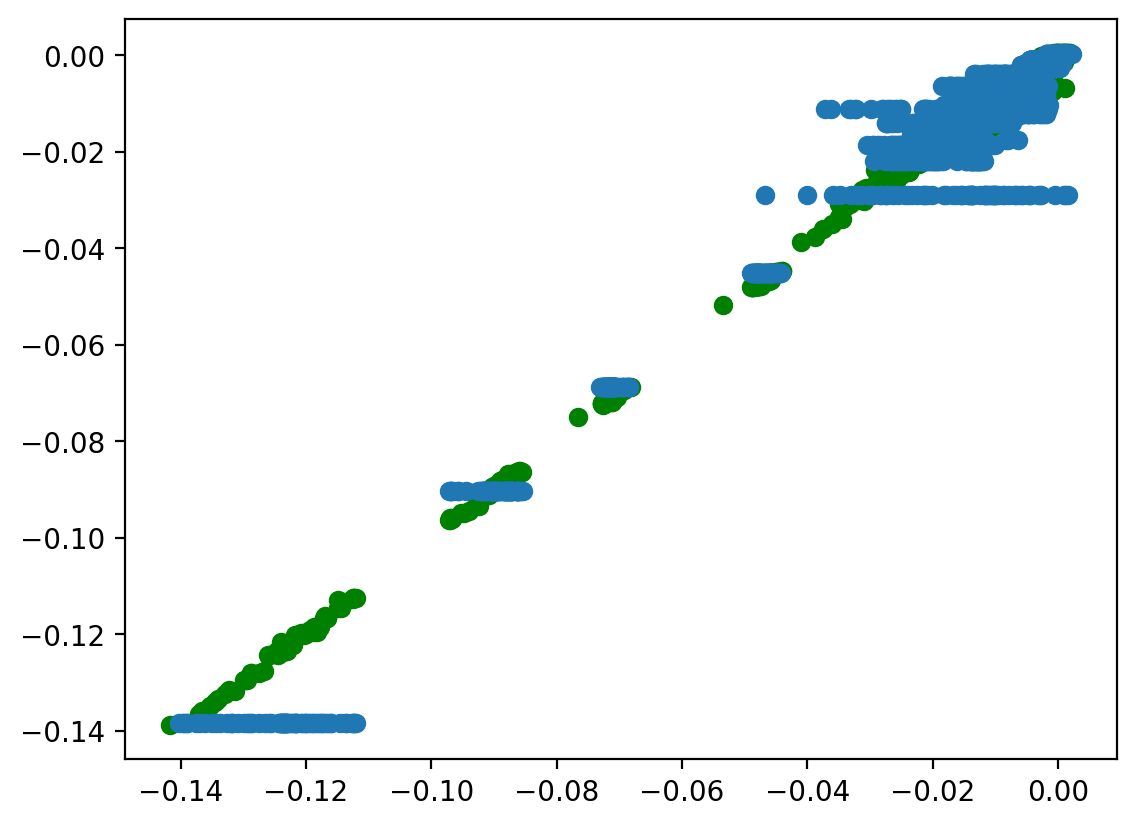

In [62]:
plt.scatter(y_train,y_pred_train,color='g')
plt.scatter(y_test,y_pred_test)

In [63]:
train_ind

array([106., 107., 108., 109., 110., 111., 112., 113., 114., 115., 116.,
       117., 118., 119., 120., 121., 122., 123., 124., 125., 126., 127.,
       128., 129., 130., 131., 132., 133., 134., 135., 136., 137., 138.,
       139., 140., 141., 142., 143., 144., 145., 146., 147., 148., 149.,
       150., 151., 152., 153., 154., 155., 156., 157., 158., 159., 160.,
       161., 162., 163., 164., 165., 166., 167., 168., 169., 170., 171.,
       172., 173., 174., 175., 176., 177., 178., 179., 180., 181.])

In [64]:
train_r = np.array(recover_train)[:,1:].astype(int)
test_r = np.array(recover_test)[:,1:].astype(int)

In [65]:
train_E2 = np.sum(y_pred_train.reshape(len(set(train_r[:,0])),-1),axis=1)
test_E2 = np.sum(y_pred_test.reshape(len(set(test_r[:,0])),-1),axis=1)

In [66]:
ml_E2=pd.concat([pd.DataFrame.from_dict({'radius':train_ind,'energy':train_E2,"set":['train']*len(train_E2)}),
pd.DataFrame.from_dict({'radius':test_ind,'energy':test_E2,"set":['test']*len(test_E2)})]).sort_index().rename(columns={0:'energy'}).set_index('radius')

In [67]:
og_E2=pd.read_csv('../ozone/basis_sets/VTZP/O3/E2.csv',index_col=0).set_index('radius')
CASPT2=pd.read_csv('../ozone/basis_sets/VTZP/O3/CASPT2.csv',index_col=0).set_index('radius')
CASSCF=pd.read_csv('../ozone/basis_sets/VTZP/O3/CASSCF.csv',index_col=0).set_index('radius')

In [68]:
ml_E2['DDCASPT2']=CASSCF['energy']+ml_E2['energy']

In [69]:
r2_score(ml_E2['DDCASPT2'],CASPT2),root_mean_squared_error(ml_E2['DDCASPT2'],CASPT2)*627.5

(0.9935008657720454, np.float64(2.5835670390198664))

In [70]:
import shap
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)

dffeat=pd.DataFrame(shap_values.abs.values.mean(axis=0),index=feat_name,columns=['shap']).reset_index().rename(columns={'index':'feat'})

dffeat['rename']=len(dffeat)*[1]

PermutationExplainer explainer: 7145it [00:49, 117.69it/s]                                                            


In [71]:

for i in feat_name:
    # print(i)
    split_i = i.split('_')
    numeric = re.sub("\D", "", i)
    for k,v in feature_dict.items():
        if k.split('_')[0]==split_i[0] or k==re.sub(r'\d+', '', i):
            if numeric.isnumeric() and len(split_i)==1:
                dffeat['rename'][dffeat['feat']==i]="$("+v+")_{"+f"{numeric}"+'}'+"$"
            elif numeric.isnumeric() and len(split_i)>1:
                dffeat['rename'][dffeat['feat']==i]="$("+v+")_{"+f"{split_i[1]}"+'}'+"$"
                
            else:
                dffeat['rename'][dffeat['feat']==i]="$"+v+"$"

/tmp/ipykernel_141850/3442971571.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dffeat['rename'][dffeat['feat']==i]="$"+v+"$"
/tmp/ipykernel_141850/3442971571.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

<Figure size 1600x2600 with 0 Axes>

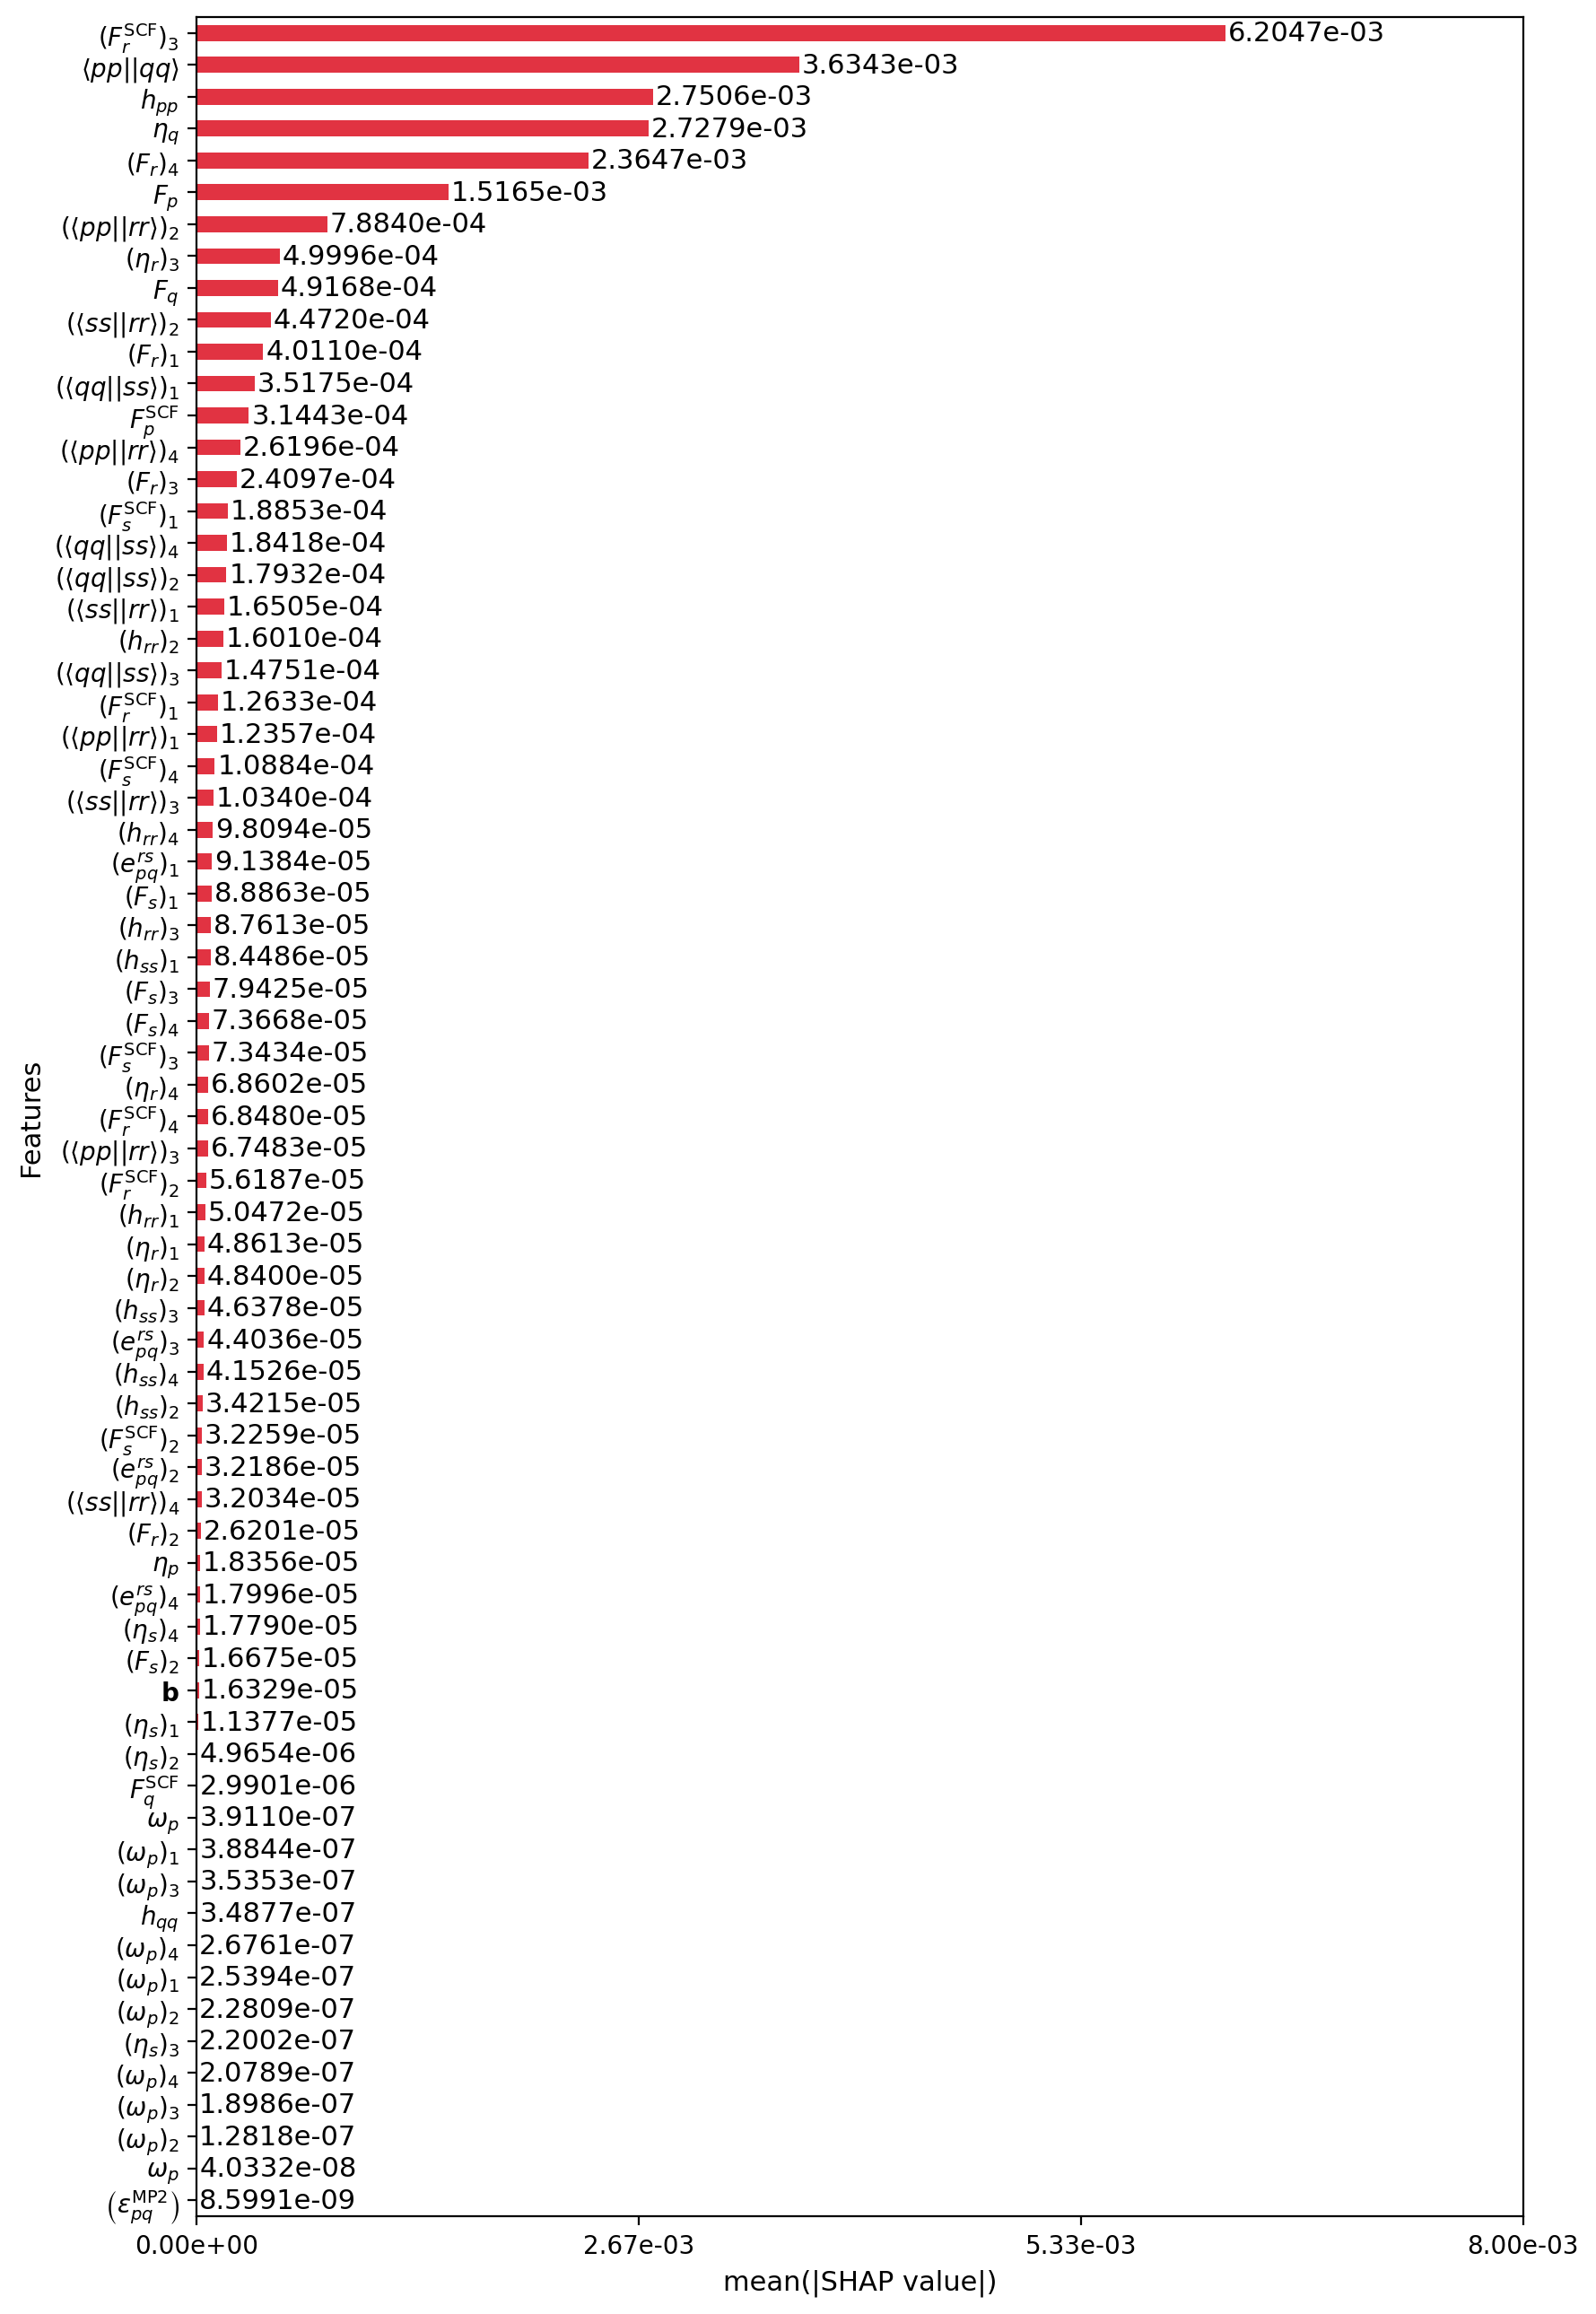

In [78]:
plt.figure(figsize=(8,13))
color_map=sns.color_palette('rocket',6)
fontsize = 11
ax=dffeat.sort_values(by=['shap','feat']).plot.barh(x='rename',y='shap',legend=False,color=color_map[3],fontsize=fontsize-1,figsize=(9,13))
ax.bar_label(ax.containers[0], fmt='%.4e',fontsize=fontsize,padding=1)
plt.xticks(np.linspace(0,8e-3,4),[f"{i:.2e}" for i in np.linspace(0,8e-3,4)])
plt.xlim(0,8e-3)
plt.xlabel('mean(|SHAP value|)',fontsize=fontsize)
plt.ylabel('Features',fontsize=fontsize)
plt.tight_layout()
# os.mkdir('images')
# os.mkdir('images')
plt.savefig('images/ozone_VTZP_shap_bar.png',dpi=300, bbox_inches='tight')
plt.show()



In [75]:
dffeat.sort_values('shap').to_excel('all_ozone_VTZP_shap.xlsx')
keepidx=np.where(np.log10(dffeat['shap'])>-5)[0]
dffeat.iloc[keepidx].to_excel('keep_ozone_VTZP_shap.xlsx')
